In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import MaxPooling1D, LSTM,  GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

In [45]:
import os

# list everything in current working directory
print(os.listdir('/content'))

['.config', 'BCICIV_2a_all_patients.csv', 'sample_data']


In [46]:
import pandas as pd

df = pd.read_csv("/content/BCICIV_2a_all_patients.csv")
print(df.shape)
print(df.head())

(492048, 26)
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -1.523659 -0.575267  ...  0.758116  3.441785  0.305517  1.137473 -1.275763   
1  1.505904  0.891796  ...  1.541586 -0.071620  0.258909 -1.448198  0.142472   
2  2.613414  4.636026  ...  2.649097 -2.137938 -1.612096 -1.610218 -0.410173   
3  5.995872  6.651295  ...  6.031554 -5.249621 -2.672998 -3.452370  0.189081   
4  4.519931  6.249573  ...  7.827097 -5.309546 -2.488783 -3.707608  1.447515   

     EEG-13    EEG-14    EEG-Pz    EEG-15    EEG-

In [47]:
import pandas as pd
import glob

# find all csvs that match the pattern
csv_files = glob.glob("/content/BCICIV_2a_*.csv")

# read them and concatenate into one DataFrame
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

print("Combined shape:", df.shape)
print(df.head())

Combined shape: (492048, 26)
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -1.523659 -0.575267  ...  0.758116  3.441785  0.305517  1.137473 -1.275763   
1  1.505904  0.891796  ...  1.541586 -0.071620  0.258909 -1.448198  0.142472   
2  2.613414  4.636026  ...  2.649097 -2.137938 -1.612096 -1.610218 -0.410173   
3  5.995872  6.651295  ...  6.031554 -5.249621 -2.672998 -3.452370  0.189081   
4  4.519931  6.249573  ...  7.827097 -5.309546 -2.488783 -3.707608  1.447515   

     EEG-13    EEG-14    EEG-Pz  

In [48]:
df = df.dropna()
eeg_columns = df.columns[4:]
print("Channels used:", eeg_columns)

Channels used: Index(['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
       'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
       'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15',
       'EEG-16'],
      dtype='object')


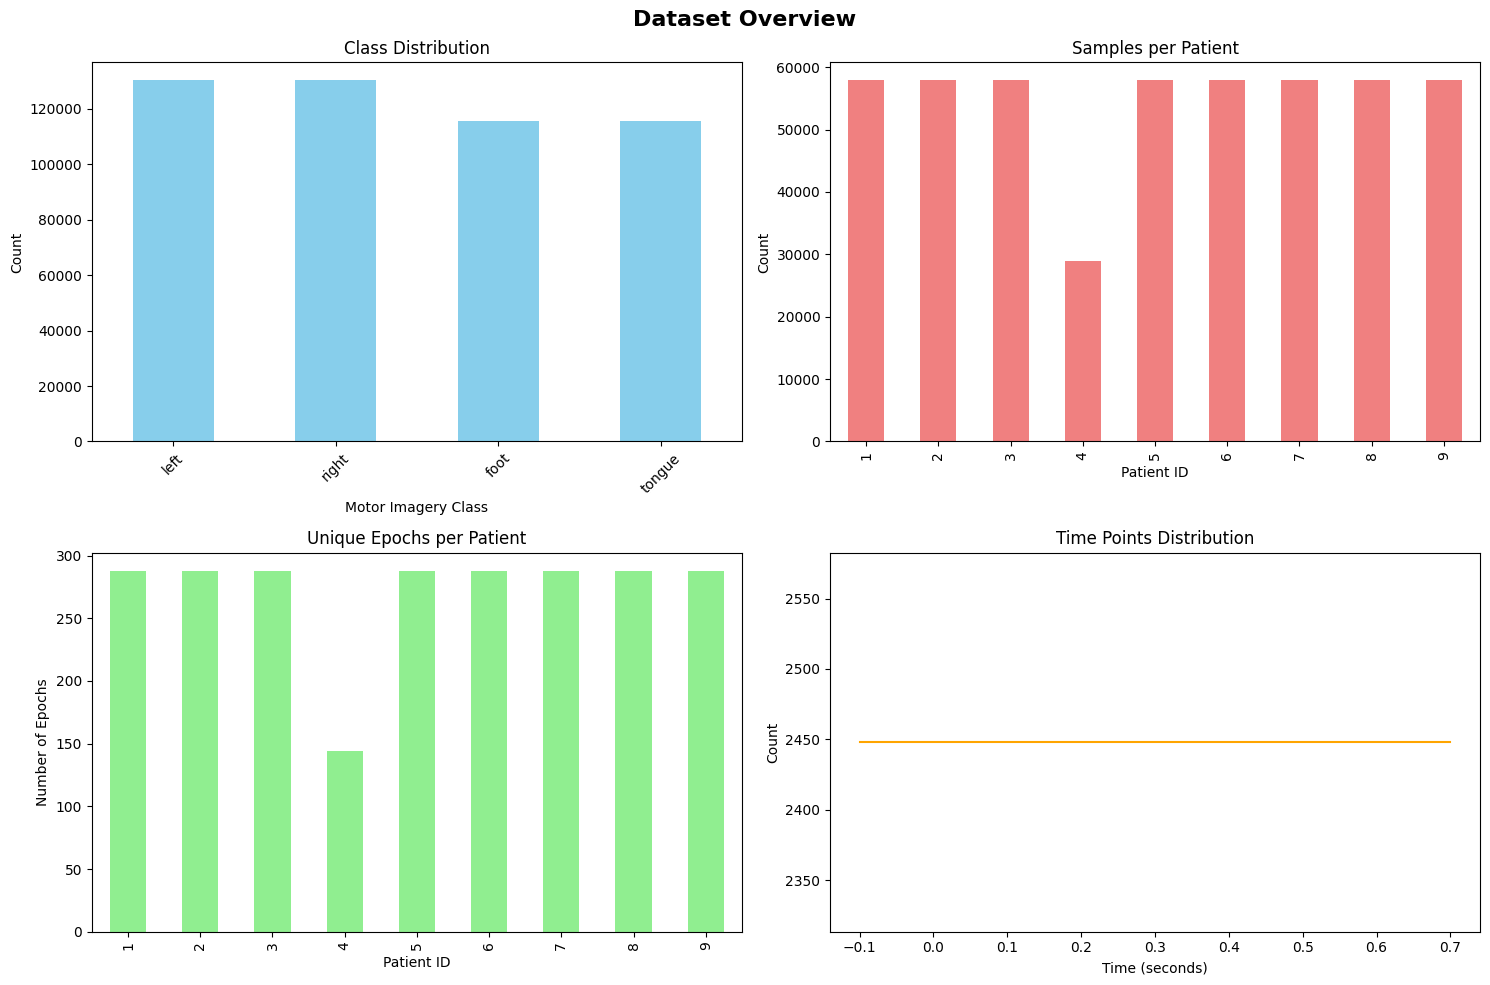

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dataset Overview', fontsize=16, fontweight='bold')

# Distribution of classes
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Class Distribution')
axes[0,0].set_xlabel('Motor Imagery Class')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Distribution of patients
df['patient'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Samples per Patient')
axes[0,1].set_xlabel('Patient ID')
axes[0,1].set_ylabel('Count')

# Distribution of epochs per patient
epoch_counts = df.groupby('patient')['epoch'].nunique()
epoch_counts.plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Unique Epochs per Patient')
axes[1,0].set_xlabel('Patient ID')
axes[1,0].set_ylabel('Number of Epochs')

# Time points distribution
time_counts = df['time'].value_counts().sort_index()
time_counts.plot(ax=axes[1,1], color='orange')
axes[1,1].set_title('Time Points Distribution')
axes[1,1].set_xlabel('Time (seconds)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [50]:
df['label'].unique()

array(['tongue', 'foot', 'right', 'left'], dtype=object)

In [51]:
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# Check class distribution
print("Class distribution before windowing:")
print(df['label'].value_counts())

# Group by epochs
grouped = df.groupby('epoch')
X, y = [], []

target_length = 201

for epoch, group in grouped:
    data = group[eeg_columns].values.T
    if data.shape[1] > target_length:
        data = data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    X.append(data)
    y.append(group['label'].iloc[0])

X = np.array(X)
y = np.array(y)
print(f"X shape after epoch grouping: {X.shape}")
print(f"y shape: {y.shape}")

# Channel-wise normalization
n_samples, n_channels, n_time_points = X.shape
X_normalized = np.zeros_like(X)

for i in range(n_samples):
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_normalized[i, ch, :] = scaler.fit_transform(X[i, ch, :].reshape(-1, 1)).flatten()

# Frequency-domain features
X_freq = np.zeros((n_samples, n_channels, n_time_points // 2 + 1))
for i in range(n_samples):
    for ch in range(n_channels):
        fft_result = fft(X_normalized[i, ch, :])
        X_freq[i, ch, :] = np.abs(fft_result[:n_time_points // 2 + 1])

# Sliding window
window_size = 50
stride = 10
X_windows, y_windows = [], []

for i in range(n_samples):
    data = X_normalized[i]
    freq_data = X_freq[i]
    num_windows = (n_time_points - window_size) // stride + 1

    for w in range(num_windows):
        start = w * stride
        end = start + window_size
        window = data[:, start:end]

        freq_start = (start * (n_time_points // 2 + 1)) // n_time_points
        freq_end = (end * (n_time_points // 2 + 1)) // n_time_points
        freq_window = freq_data[:, freq_start:freq_end]

        if freq_window.shape[1] < window_size:
            freq_window = np.pad(freq_window, ((0, 0), (0, window_size - freq_window.shape[1])), mode='constant')
        elif freq_window.shape[1] > window_size:
            freq_window = freq_window[:, :window_size]

        combined = np.stack([window, freq_window], axis=-1)
        X_windows.append(combined)
        y_windows.append(y[i])

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)
print(f"X_windows shape (before reshape): {X_windows.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)
y_categorical = tf.keras.utils.to_categorical(y_encoded)
print(f"Encoded y shape (categorical): {y_categorical.shape}")

# Reshape: (samples, time_steps, channels, features) -> (samples, time_steps, channels * features)
X_windows = X_windows.transpose(0, 2, 1, 3)
X_windows = X_windows.reshape(X_windows.shape[0], X_windows.shape[1], X_windows.shape[2] * X_windows.shape[3])
print(f"X_windows shape (final): {X_windows.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Class distribution before windowing:
label
left      130248
right     130248
foot      115776
tongue    115776
Name: count, dtype: int64
X shape after epoch grouping: (632, 22, 201)
y shape: (632,)
X_windows shape (before reshape): (10112, 22, 50, 2)
Encoded y shape (categorical): (10112, 4)
X_windows shape (final): (10112, 50, 44)
Train: (8089, 50, 44), (8089, 4)
Test: (2023, 50, 44), (2023, 4)


Raw EEG Signal Visualization (Sample) 


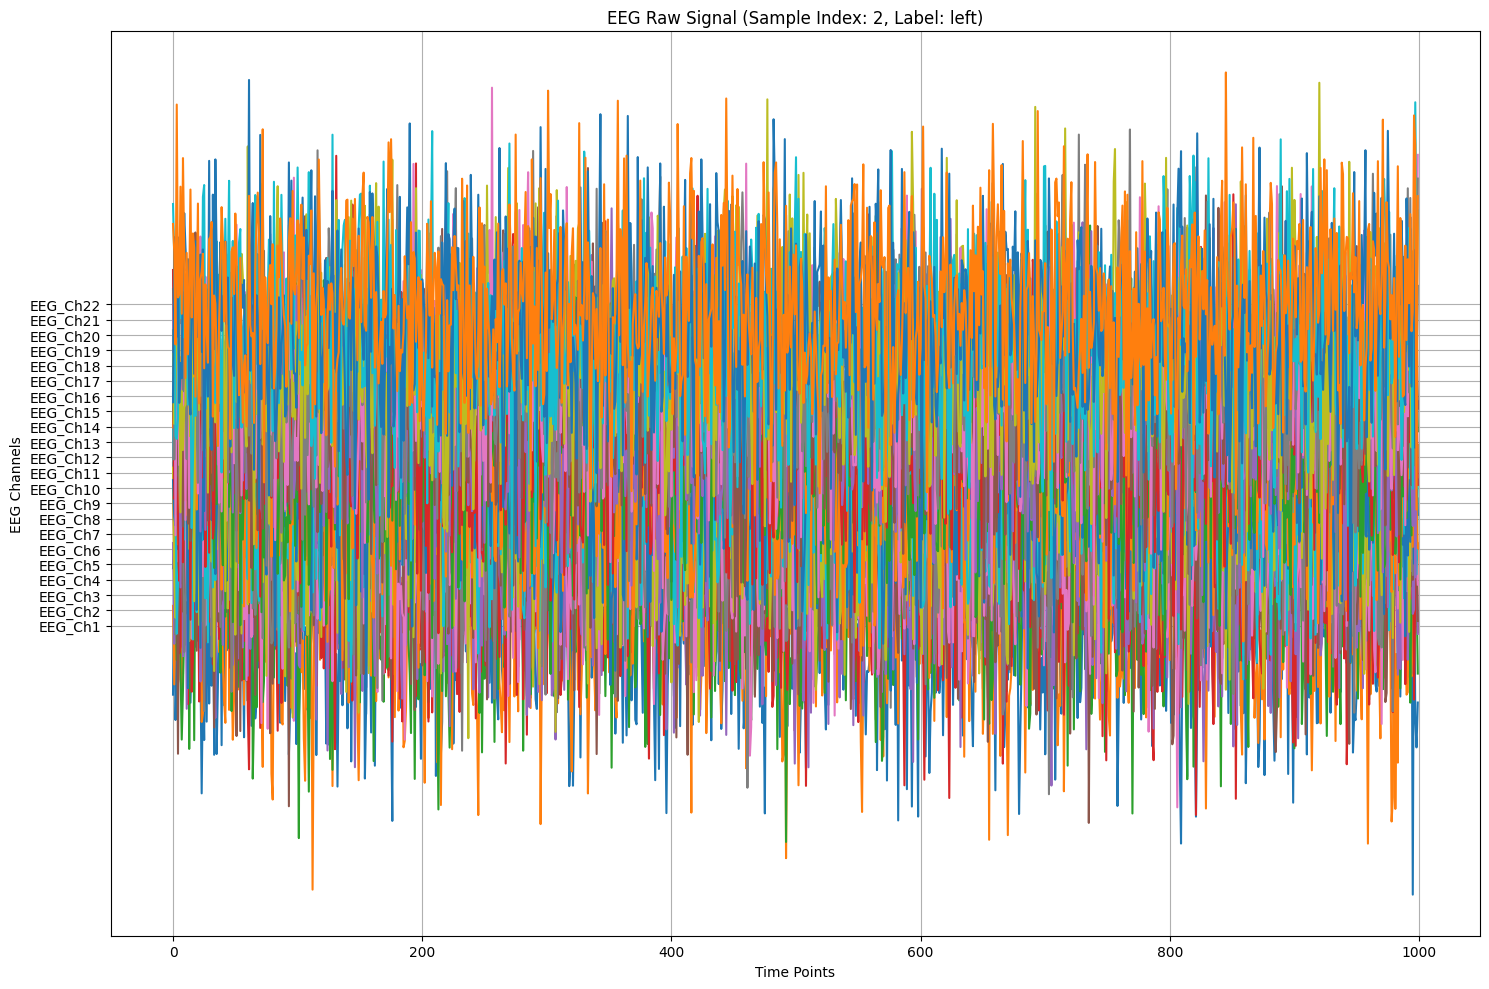


 Raw vs. Normalized EEG Signal Comparison 


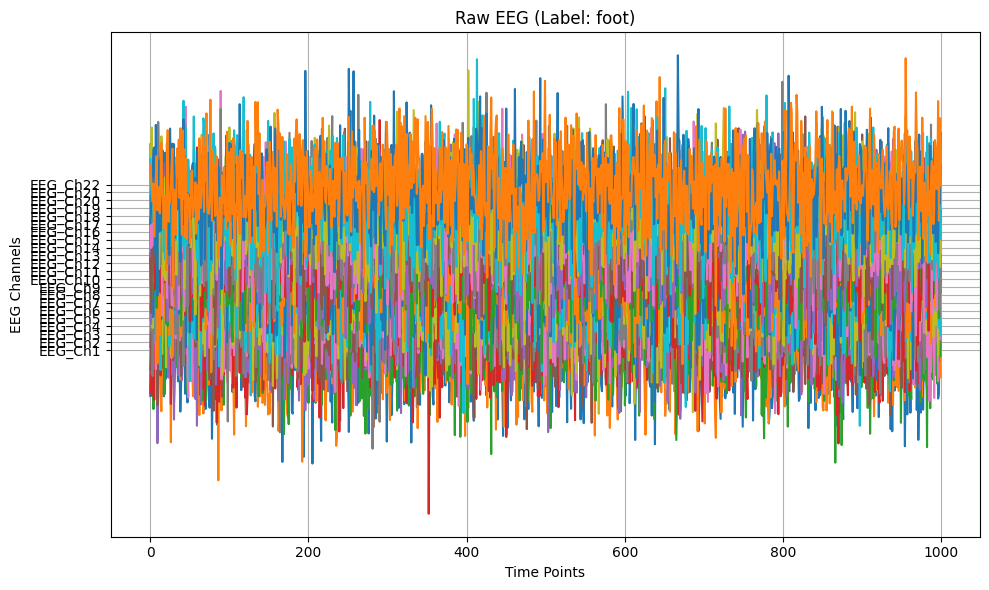

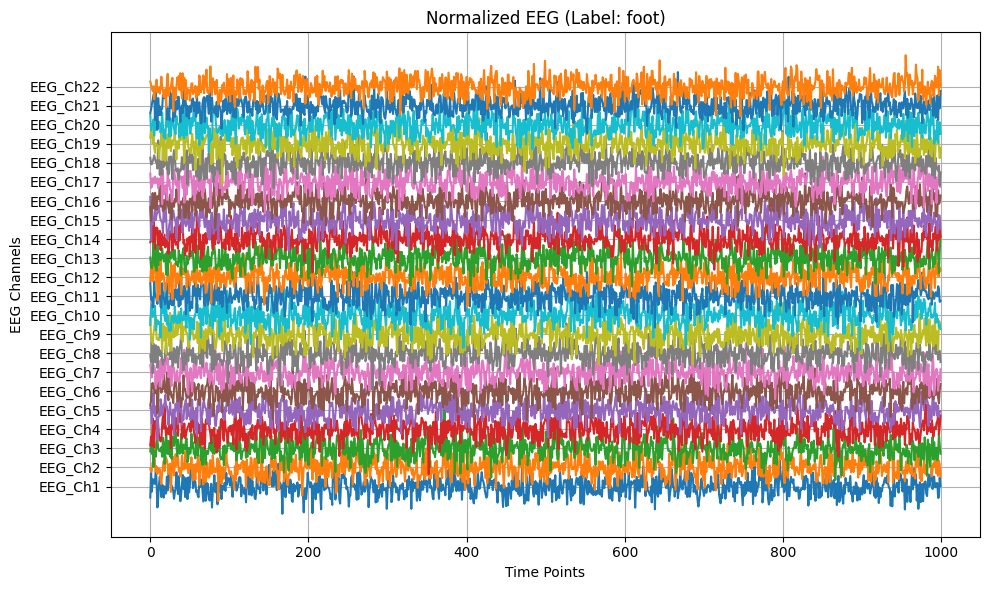


 EEG Signal Frequency-Domain Visualization (FFT) 


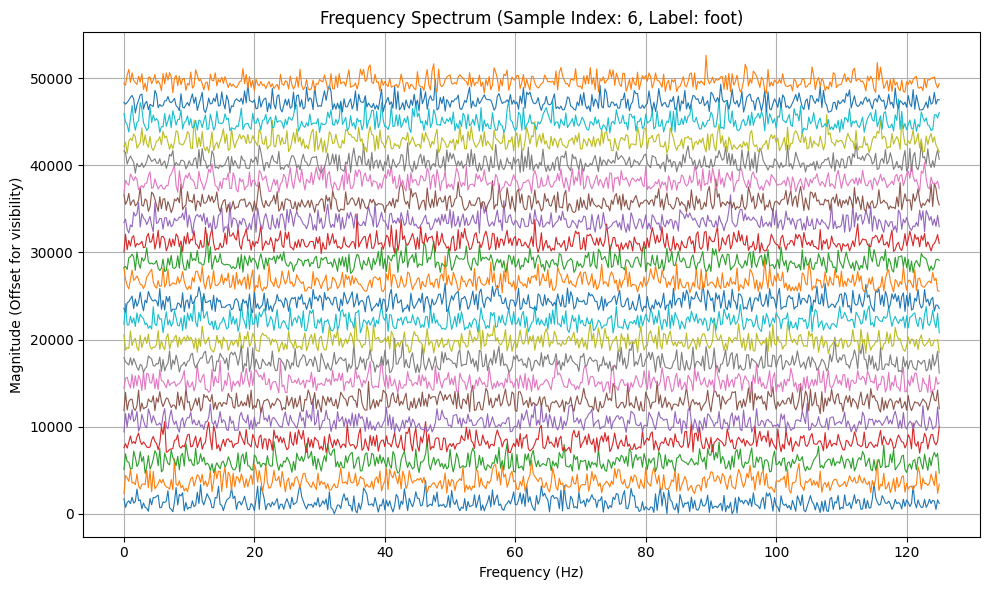


 Spectrogram-like EEG Heatmap 


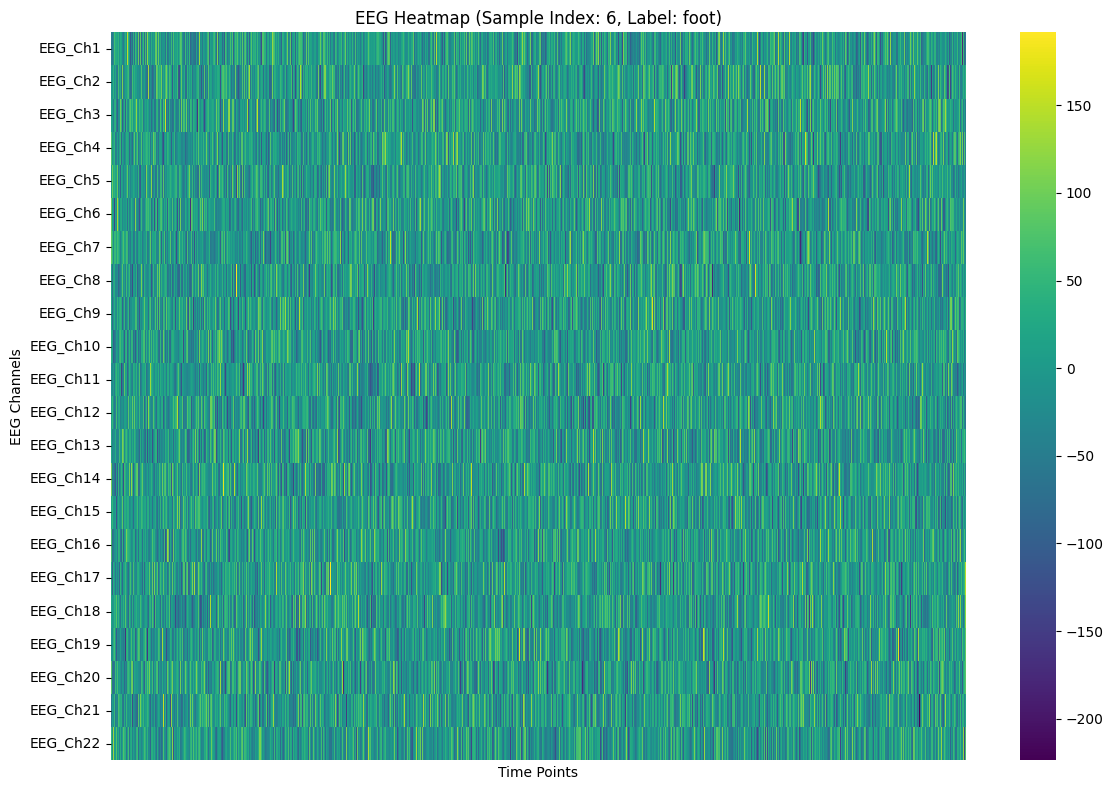


 EEG Band Power Calculation 


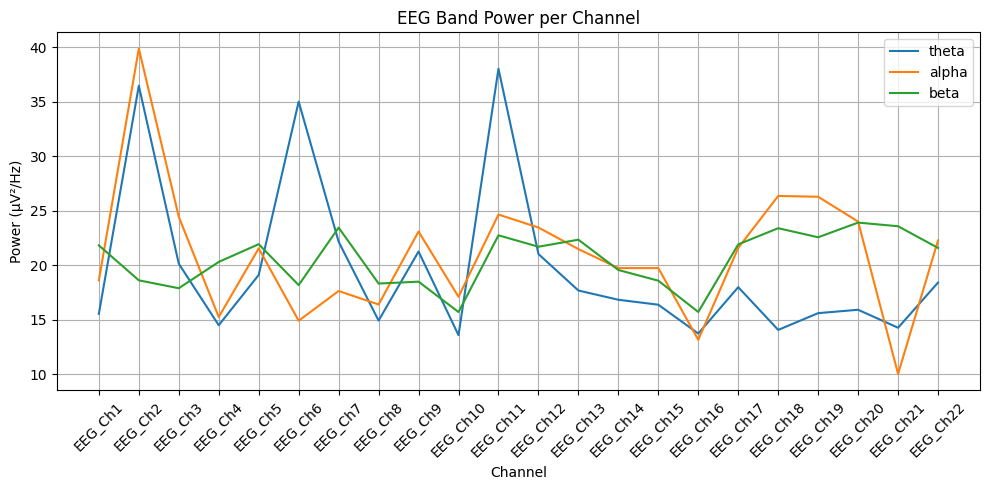


 PCA and t-SNE Feature Visualization 


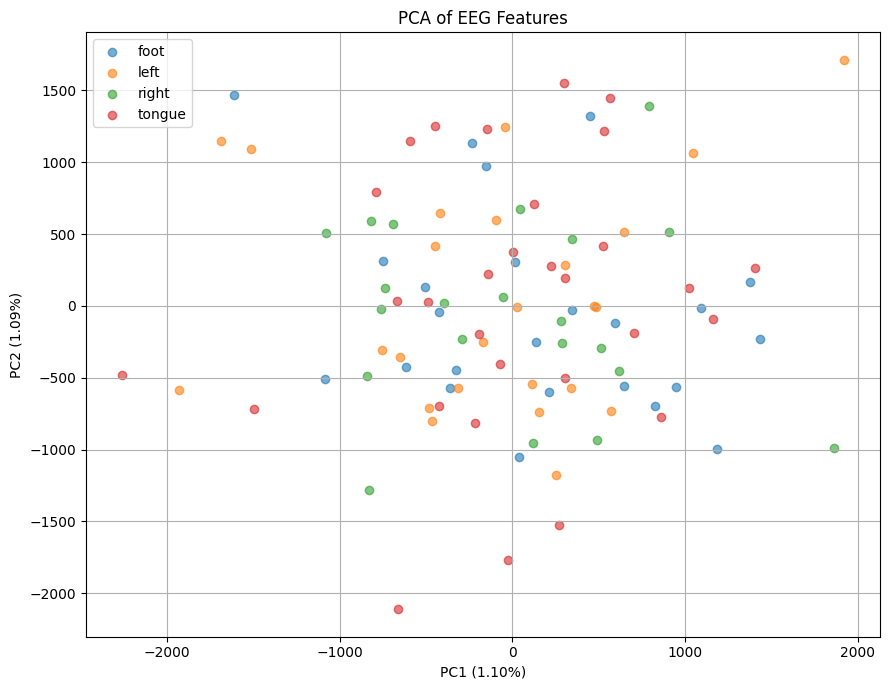

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy.fft import fft, rfftfreq
from scipy.signal import welch
import random

#  Parameters for dummy data
n_samples = 100
n_channels = 22  # Standard for BCIC IV 2a
n_time_points = 1000  # Assuming 4 seconds at 250 Hz
sf = 250  # Sampling frequency

# Dummy raw EEG data (X)
X = np.random.randn(n_samples, n_channels, n_time_points) * 50

# Dummy labels (y)
labels = ['left', 'right', 'foot', 'tongue']
y = np.array(random.choices(labels, k=n_samples))

# EEG channel names
eeg_columns = [f'EEG_Ch{i+1}' for i in range(n_channels)]

# Normalize EEG data
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_time_points)
X_normalized_reshaped = scaler.fit_transform(X_reshaped)
X_normalized = X_normalized_reshaped.reshape(n_samples, n_channels, n_time_points)

# Frequency domain (FFT)
X_freq_real = np.abs(np.fft.rfft(X, axis=-1))

# Windowed features for PCA/t-SNE
X_windows = X  # Placeholder

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)

#  Visualization: Raw EEG
print("Raw EEG Signal Visualization (Sample) ")
left_indices = np.where(y == 'left')[0]
sample_idx = left_indices[0] if len(left_indices) > 0 else random.randint(0, n_samples - 1)
sample_data = X[sample_idx]

plt.figure(figsize=(15, 10))
for ch in range(sample_data.shape[0]):
    plt.plot(sample_data[ch] + ch * 10, label=f'Ch {eeg_columns[ch]}')
plt.yticks([ch * 10 for ch in range(sample_data.shape[0])], eeg_columns)
plt.title(f'EEG Raw Signal (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

#  Comparison: Raw vs Normalized
print("\n Raw vs. Normalized EEG Signal Comparison ")
target_class = 'foot'
class_indices = np.where(y == target_class)[0]
sample_idx = class_indices[0] if len(class_indices) > 0 else random.randint(0, n_samples - 1)
raw_sample = X[sample_idx]
norm_sample = X_normalized[sample_idx]
start_time, end_time = 0, raw_sample.shape[1]
raw_clip = raw_sample[:, start_time:end_time]
norm_clip = norm_sample[:, start_time:end_time]
time_points = np.arange(start_time, end_time)

# Raw EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, raw_clip[ch] + ch * 10)
plt.yticks([ch * 10 for ch in range(n_channels)], eeg_columns)
plt.title(f'Raw EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalized EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, norm_clip[ch] + ch * 2)
plt.yticks([ch * 2 for ch in range(n_channels)], eeg_columns)
plt.title(f'Normalized EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# Frequency-Domain Visualization
print("\n EEG Signal Frequency-Domain Visualization (FFT) ")
sample_freq = X_freq_real[sample_idx]
freqs = rfftfreq(n_time_points, d=1/sf)

plt.figure(figsize=(10, 6))
offset = np.max(sample_freq) * 0.5
for ch in range(n_channels):
    plt.plot(freqs, sample_freq[ch] + ch * offset, lw=0.8)
plt.title(f'Frequency Spectrum (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Offset for visibility)")
plt.grid(True)
plt.tight_layout()
plt.show()

#  Heatmap
print("\n Spectrogram-like EEG Heatmap ")
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data, cmap='viridis', yticklabels=eeg_columns, xticklabels=False)
plt.title(f'EEG Heatmap (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.tight_layout()
plt.show()

# Band Power
print("\n EEG Band Power Calculation ")
def bandpower(data, sf, band, window_sec=None):
    low, high = band
    nperseg = int(window_sec * sf) if window_sec else None
    freqs, psd = welch(data, sf, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(psd[idx_band]) if np.any(idx_band) else 0.0

bands = {'theta': (4, 7), 'alpha': (8, 13), 'beta': (14, 30)}
band_powers = {band: [] for band in bands}

for ch in range(n_channels):
    signal = sample_data[ch]
    for band, band_range in bands.items():
        band_powers[band].append(bandpower(signal, sf, band_range, window_sec=2))

plt.figure(figsize=(10, 5))
for band in bands:
    plt.plot(band_powers[band], label=band)
plt.xticks(np.arange(n_channels), eeg_columns, rotation=45)
plt.title("EEG Band Power per Channel")
plt.xlabel("Channel")
plt.ylabel("Power (μV²/Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  PCA Visualization
print("\n PCA and t-SNE Feature Visualization ")
X_flat = X_windows.reshape(n_samples, -1)
y_labels = np.argmax(y_categorical, axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(9, 7))
for i in np.unique(y_labels):
    label = label_encoder.classes_[i] if i < len(label_encoder.classes_) else f'Class {i}'
    plt.scatter(X_pca[y_labels == i, 0], X_pca[y_labels == i, 1], label=label, alpha=0.6)
plt.title("PCA of EEG Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
# Define input shape from X_train
channels = X.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4

In [54]:
channels


22

In [55]:
def CNN_LSTM(input_shape, num_classes, dropoutRate=0.3, l2_reg = 0.002):
    input1 = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(input1)
    x = BatchNormalization()(x)
    x = Dropout(dropoutRate)(x)

    x = Conv1D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropoutRate)(x)

    x = LSTM(128, return_sequences=True, dropout=dropoutRate)(x)
    x = LSTM(64, dropout=dropoutRate)(x)

    x = Dense(64, activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=x)

In [56]:
def GRU_Flatten_Model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True)(inputs)
    flatten_out = Flatten()(gru_out)
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    return Model(inputs=inputs, outputs=outputs)

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dropout, Flatten, Dense
from tensorflow.keras import regularizers

def GRU_Regularized_Model(input_shape, num_classes, dropout_rate=0.2, l2_reg=0.002):
    inputs = Input(shape=input_shape)

    # GRU layer with L2 regularization
    gru_out = GRU(256, return_sequences=True,
                  kernel_regularizer=regularizers.l2(l2_reg))(inputs)

    # Dropout for regularization
    gru_out = Dropout(dropout_rate)(gru_out)

    # Flatten before dense layer
    flatten_out = Flatten()(gru_out)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(flatten_out)

    return Model(inputs=inputs, outputs=outputs)

**Adding Different Types of Noise and Augmentation Techniques to EEG Data**

In [58]:
import numpy as np

# 1) Gaussian noise
def add_gaussian_noise(X, sigma=0.01):
    # X shape: (n_samples, timesteps, features)
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

# 2) Impulse noise (random spikes)
def add_impulse_noise(X, prob=0.001, amp=5.0):
    Xr = X.copy()
    n_samples, t, f = X.shape
    # probability per sample-time-feature to have spike
    mask = np.random.rand(n_samples, t, f) < prob
    spikes = np.random.choice([amp, -amp], size=(n_samples, t, f))
    Xr[mask] = Xr[mask] + spikes[mask]
    return Xr

# 3) Channel dropout (zero out whole channel with p)
def channel_dropout(X, p=0.1):
    Xr = X.copy()
    n, t, f = X.shape
    n_ch = f  # if features = channels, else adjust
    for i in range(n):
        drop_mask = np.random.rand(n_ch) < p
        if np.any(drop_mask):
            # set all time points for dropped channels to zero
            Xr[i, :, drop_mask] = 0
    return Xr

# 4) Time shift (circular shift)
def time_shift(X, max_shift=5):
    Xr = X.copy()
    for i in range(X.shape[0]):
        shift = np.random.randint(-max_shift, max_shift+1)
        Xr[i] = np.roll(Xr[i], shift, axis=0)
    return Xr

# 5) Mixup (mix two samples)
def mixup(X, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = np.random.permutation(len(X))
    Xm = lam * X + (1-lam) * X[idx]
    ym = lam * y + (1-lam) * y[idx]
    return Xm, ym


**Define GRU Baseline Model and Training Function for Experiments**

In [62]:
# helper builder so experiment runner knows which model to build
def build_baseline_gru_reg(input_shape, num_classes):
    return GRU_Regularized_Model(
        input_shape=input_shape,
        num_classes=num_classes,
        dropout_rate=0.2,
        l2_reg=0.002
    )

In [63]:
# Helper function that builds your GRU model
def build_baseline_gru_reg(input_shape, num_classes):
    return GRU_Regularized_Model(
        input_shape=input_shape,
        num_classes=num_classes,
        dropout_rate=0.2,
        l2_reg=0.002
    )

# Modified experiment runner
def run_experiment_with_data(name, build_fn, X_tr, y_tr, epochs=30, batch_size=32):
    print("\n  Running:", name, " ")
    tf.keras.backend.clear_session()

    # Automatically detect input shape and number of classes
    input_shape = X_tr.shape[1:]
    num_classes = y_tr.shape[1]

    # Build and compile model
    model = build_fn(input_shape, num_classes)
    compile_model(model)

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]

    # Train the model
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=2
    )

    # Evaluate
    preds = model.predict(X_test)
    acc = (preds.argmax(axis=1) == y_test.argmax(axis=1)).mean()
    print(name, "test acc:", acc)

    return {'name': name, 'acc': float(acc)}


In [64]:
# Helper function to compile the model
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


In [66]:
# Create Gaussian + time-shift augmented dataset
X_aug = add_gaussian_noise(X_train, sigma=0.02)
X_aug = time_shift(X_aug, max_shift=3)
y_aug = y_train.copy()

# Combine original and augmented data
X_train_aug = np.concatenate([X_train, X_aug], axis=0)
y_train_aug = np.concatenate([y_train, y_aug], axis=0)

print("New train shape:", X_train_aug.shape, y_train_aug.shape)


New train shape: (16178, 50, 44) (16178, 4)


In [67]:
res = run_experiment_with_data(
    "baseline_with_gauss",
    build_baseline_gru_reg,
    X_train_aug,
    y_train_aug,
    epochs=30
)


  Running: baseline_with_gauss  
Epoch 1/30
506/506 - 8s - 17ms/step - accuracy: 0.3071 - loss: 1.5615 - val_accuracy: 0.2966 - val_loss: 1.5009 - learning_rate: 5.0000e-04
Epoch 2/30
506/506 - 3s - 6ms/step - accuracy: 0.3811 - loss: 1.4016 - val_accuracy: 0.3302 - val_loss: 1.4484 - learning_rate: 5.0000e-04
Epoch 3/30
506/506 - 5s - 9ms/step - accuracy: 0.4522 - loss: 1.2911 - val_accuracy: 0.3584 - val_loss: 1.4928 - learning_rate: 5.0000e-04
Epoch 4/30
506/506 - 3s - 6ms/step - accuracy: 0.5383 - loss: 1.1454 - val_accuracy: 0.4449 - val_loss: 1.3431 - learning_rate: 5.0000e-04
Epoch 5/30
506/506 - 3s - 6ms/step - accuracy: 0.6585 - loss: 0.9199 - val_accuracy: 0.5255 - val_loss: 1.2094 - learning_rate: 5.0000e-04
Epoch 6/30
506/506 - 3s - 6ms/step - accuracy: 0.7740 - loss: 0.6639 - val_accuracy: 0.6426 - val_loss: 1.0188 - learning_rate: 5.0000e-04
Epoch 7/30
506/506 - 4s - 8ms/step - accuracy: 0.8767 - loss: 0.4274 - val_accuracy: 0.7420 - val_loss: 0.8137 - learning_rate: 5.0

**Add Random Impulse Noise (Spikes) to EEG Signals**

In [68]:
import numpy as np

# Impulse noise: randomly add small spikes to EEG signals
def add_impulse_noise(X, num_spikes=10, intensity=0.5):
    X_noisy = X.copy()
    for i in range(X.shape[0]):  # for each sample
        for _ in range(num_spikes):
            t = np.random.randint(0, X.shape[1])  # random time index
            f = np.random.randint(0, X.shape[2])  # random channel
            X_noisy[i, t, f] += intensity * np.random.choice([-1, 1])  # add positive or negative spike
    return X_noisy


In [69]:
# Apply impulse noise on EEG data
X_impulse = add_impulse_noise(X_train, num_spikes=8, intensity=0.3)
y_impulse = y_train.copy()

# Combine original + noisy data
X_train_impulse = np.concatenate([X_train, X_impulse], axis=0)
y_train_impulse = np.concatenate([y_train, y_impulse], axis=0)

print("New train shape:", X_train_impulse.shape, y_train_impulse.shape)


New train shape: (16178, 50, 44) (16178, 4)


In [70]:
# Run experiment with impulse noise data
res_impulse = run_experiment_with_data(
    "baseline_with_impulse_noise",
    build_baseline_gru_reg,
    X_train_impulse,
    y_train_impulse,
    epochs=30
)



  Running: baseline_with_impulse_noise  
Epoch 1/30
506/506 - 5s - 10ms/step - accuracy: 0.3253 - loss: 1.5388 - val_accuracy: 0.3080 - val_loss: 1.4923 - learning_rate: 5.0000e-04
Epoch 2/30
506/506 - 3s - 7ms/step - accuracy: 0.4381 - loss: 1.3291 - val_accuracy: 0.3347 - val_loss: 1.4566 - learning_rate: 5.0000e-04
Epoch 3/30
506/506 - 3s - 6ms/step - accuracy: 0.5354 - loss: 1.1581 - val_accuracy: 0.4231 - val_loss: 1.3811 - learning_rate: 5.0000e-04
Epoch 4/30
506/506 - 3s - 6ms/step - accuracy: 0.6729 - loss: 0.9037 - val_accuracy: 0.5482 - val_loss: 1.1745 - learning_rate: 5.0000e-04
Epoch 5/30
506/506 - 4s - 8ms/step - accuracy: 0.8266 - loss: 0.5632 - val_accuracy: 0.6851 - val_loss: 0.9460 - learning_rate: 5.0000e-04
Epoch 6/30
506/506 - 4s - 9ms/step - accuracy: 0.9414 - loss: 0.2732 - val_accuracy: 0.7692 - val_loss: 0.7659 - learning_rate: 5.0000e-04
Epoch 7/30
506/506 - 3s - 6ms/step - accuracy: 0.9721 - loss: 0.1770 - val_accuracy: 0.7855 - val_loss: 0.7730 - learning_r

**Channel Dropout Data Augmentation Experiment**

In [71]:
import numpy as np

def add_channel_dropout(X, drop_prob=0.1):
    # X shape: (n_samples, timesteps, features)
    Xc = X.copy()
    n_samples, t, f = Xc.shape

    for i in range(n_samples):
        mask = np.random.rand(f) < drop_prob
        if np.any(mask):
            Xc[i, :, mask] = 0.0
    return Xc

# Create augmented training set: original + channel-dropped
drop_prob = 0.1
X_chan = add_channel_dropout(X_train, drop_prob=drop_prob)
y_chan = y_train.copy()

X_train_chan = np.concatenate([X_train, X_chan], axis=0)
y_train_chan = np.concatenate([y_train, y_chan], axis=0)

print("Augmented train shape:", X_train_chan.shape, y_train_chan.shape)

res_chan = run_experiment_with_data(
    "baseline_with_channel_dropout",
    build_baseline_gru_reg,
    X_train_chan,
    y_train_chan,
    epochs=30,
    batch_size=32
)
print("Result:", res_chan)


Augmented train shape: (16178, 50, 44) (16178, 4)

  Running: baseline_with_channel_dropout  
Epoch 1/30
506/506 - 5s - 9ms/step - accuracy: 0.2947 - loss: 1.5788 - val_accuracy: 0.2912 - val_loss: 1.5019 - learning_rate: 5.0000e-04
Epoch 2/30
506/506 - 4s - 8ms/step - accuracy: 0.3754 - loss: 1.4087 - val_accuracy: 0.3050 - val_loss: 1.4749 - learning_rate: 5.0000e-04
Epoch 3/30
506/506 - 4s - 9ms/step - accuracy: 0.4166 - loss: 1.3413 - val_accuracy: 0.3312 - val_loss: 1.4522 - learning_rate: 5.0000e-04
Epoch 4/30
506/506 - 3s - 6ms/step - accuracy: 0.4792 - loss: 1.2513 - val_accuracy: 0.3564 - val_loss: 1.4613 - learning_rate: 5.0000e-04
Epoch 5/30
506/506 - 4s - 8ms/step - accuracy: 0.5527 - loss: 1.1271 - val_accuracy: 0.4241 - val_loss: 1.3716 - learning_rate: 5.0000e-04
Epoch 6/30
506/506 - 3s - 6ms/step - accuracy: 0.6530 - loss: 0.9302 - val_accuracy: 0.5161 - val_loss: 1.2429 - learning_rate: 5.0000e-04
Epoch 7/30
506/506 - 3s - 6ms/step - accuracy: 0.7767 - loss: 0.6792 - v

**Mixup Data Augmentation Experiment**

In [72]:
import numpy as np

def mixup_pair(X, y, alpha=0.2):
    """Create a mixup version of X,y pairwise (same length)."""
    lam = np.random.beta(alpha, alpha, size=(X.shape[0], 1, 1))
    idx = np.random.permutation(X.shape[0])
    Xm = lam * X + (1 - lam) * X[idx]
    ym = lam.reshape(-1,1) * y + (1 - lam).reshape(-1,1) * y[idx]
    return Xm, ym

# Create one mixup augmentation copy and combine with original
X_mix, y_mix = mixup_pair(X_train, y_train, alpha=0.2)
X_train_mix = np.concatenate([X_train, X_mix], axis=0)
y_train_mix = np.concatenate([y_train, y_mix], axis=0)
print("Mixup train shape:", X_train_mix.shape, y_train_mix.shape)

# Run experiment (re-uses your builder + runner)
res_mix = run_experiment_with_data(
    "baseline_with_mixup",
    build_baseline_gru_reg,
    X_train_mix,
    y_train_mix,
    epochs=30,
    batch_size=32
)
print("Mixup result:", res_mix)


Mixup train shape: (16178, 50, 44) (16178, 4)

  Running: baseline_with_mixup  
Epoch 1/30
506/506 - 5s - 10ms/step - accuracy: 0.3304 - loss: 1.5283 - val_accuracy: 0.3178 - val_loss: 1.4918 - learning_rate: 5.0000e-04
Epoch 2/30
506/506 - 3s - 7ms/step - accuracy: 0.4281 - loss: 1.3436 - val_accuracy: 0.3539 - val_loss: 1.4621 - learning_rate: 5.0000e-04
Epoch 3/30
506/506 - 5s - 10ms/step - accuracy: 0.5115 - loss: 1.2132 - val_accuracy: 0.4182 - val_loss: 1.3609 - learning_rate: 5.0000e-04
Epoch 4/30
506/506 - 3s - 7ms/step - accuracy: 0.6186 - loss: 1.0366 - val_accuracy: 0.4627 - val_loss: 1.3704 - learning_rate: 5.0000e-04
Epoch 5/30
506/506 - 4s - 7ms/step - accuracy: 0.7484 - loss: 0.7900 - val_accuracy: 0.5729 - val_loss: 1.1804 - learning_rate: 5.0000e-04
Epoch 6/30
506/506 - 3s - 6ms/step - accuracy: 0.8477 - loss: 0.5846 - val_accuracy: 0.6525 - val_loss: 0.9849 - learning_rate: 5.0000e-04
Epoch 7/30
506/506 - 3s - 6ms/step - accuracy: 0.9188 - loss: 0.4289 - val_accuracy:

**On-the-Fly Data Augmentation for EEG Signals**

In [73]:
from tensorflow.keras.utils import Sequence

class EEGAugGenerator(Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True, augment=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_idxs = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        Xb = self.X[batch_idxs].copy()
        yb = self.y[batch_idxs].copy()
        if self.augment:
            # apply a random small mix of augmentations:
            Xb = add_gaussian_noise(Xb, sigma=0.01)
            Xb = add_impulse_noise(Xb, num_spikes=2, intensity=0.2)
            Xb = add_channel_dropout(Xb, drop_prob=0.05)
            Xb = time_shift(Xb, max_shift=2)
        return Xb, yb

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Example: train with generator
train_gen = EEGAugGenerator(X_train, y_train, batch_size=32, augment=True)
val_gen   = EEGAugGenerator(X_test, y_test, batch_size=32, augment=False)

# Build and compile a fresh model
tf.keras.backend.clear_session()
model = build_baseline_gru_reg(X_train.shape[1:], y_train.shape[1])
compile_model(model)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

hist = model.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=callbacks, verbose=2)
preds = model.predict(X_test)
acc = (preds.argmax(axis=1) == y_test.argmax(axis=1)).mean()
print("On-the-fly augmentation test acc:", acc)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 - 6s - 24ms/step - accuracy: 0.2715 - loss: 1.6614 - val_accuracy: 0.2694 - val_loss: 1.5526 - learning_rate: 5.0000e-04
Epoch 2/30
253/253 - 3s - 11ms/step - accuracy: 0.2758 - loss: 1.5477 - val_accuracy: 0.2615 - val_loss: 1.5369 - learning_rate: 5.0000e-04
Epoch 3/30
253/253 - 3s - 11ms/step - accuracy: 0.2982 - loss: 1.4932 - val_accuracy: 0.2818 - val_loss: 1.5078 - learning_rate: 5.0000e-04
Epoch 4/30
253/253 - 3s - 11ms/step - accuracy: 0.3182 - loss: 1.4664 - val_accuracy: 0.2748 - val_loss: 1.4701 - learning_rate: 5.0000e-04
Epoch 5/30
253/253 - 4s - 15ms/step - accuracy: 0.3060 - loss: 1.4560 - val_accuracy: 0.2872 - val_loss: 1.4495 - learning_rate: 5.0000e-04
Epoch 6/30
253/253 - 3s - 11ms/step - accuracy: 0.3229 - loss: 1.4417 - val_accuracy: 0.2709 - val_loss: 1.4613 - learning_rate: 5.0000e-04
Epoch 7/30
253/253 - 3s - 11ms/step - accuracy: 0.3339 - loss: 1.4267 - val_accuracy: 0.3045 - val_loss: 1.4434 - learning_rate: 5.0000e-04
Epoch 8/30
253/253 - 3s - 11ms/